### Bhavesh Hiranand Chainani
#### Silent Eight Data Science Assessment

In [171]:
## Import all relevant python libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE 

In [172]:
## Read in data
data = pd.read_csv('data/all_trxns.csv')

### Exploratory Data Analysis (EDA)

In [173]:
data.head()

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount
0,C12976926337644,UK,N,2021-03-20 05:59:25,77697395249488,CN,OTHER,JPY,48625.25
1,C12976926337644,UK,N,2021-05-02 03:00:38,77697395249488,CN,PAYMENT,GBP,20637.21
2,C12976926337644,UK,N,2021-05-23 22:15:15,77697395249488,NaN,PAYMENT,USD,56691.27
3,C12976926337644,UK,N,2021-07-07 21:36:50,77697395249488,NaN,PAYMENT,CNY,343864.71
4,C12976926337644,UK,N,2021-09-02 00:14:03,77697395249488,NaN,PAYMENT,USD,57247.35


In [174]:
data.shape
# 5302 rows, 9 columns

(5302, 9)

In [175]:
data.dtypes

customer                object
customer_country        object
fraud_flag              object
timestamp               object
counterparty             int64
counterparty_country    object
type                    object
ccy                     object
amount                  object
dtype: object

In [176]:
data.describe()

,counterparty
count,5.302000e+03
mean,5.626952e+13
std,2.609480e+13
min,1.136138e+13
25%,3.259593e+13
50%,5.715527e+13
75%,7.748636e+13
max,9.972984e+13


In [177]:
## We notice that the timestamp column is a string, hence it is important to convert it to datetime format
type(data['timestamp'][0])

str

In [178]:
## convert timestamp column from string to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [179]:
## Identify any null values
data.isna().sum()

customer                  0
customer_country          0
fraud_flag                0
timestamp                 0
counterparty              0
counterparty_country    499
type                      0
ccy                       0
amount                    0
dtype: int64

In [180]:
# We can see the counterparty_country is the only column with null values. 
# We will leave it for now as we do not want to remove any uneccessary rows, 
# given that the dataset is relatively small.

In [181]:
# remove unneccessary strings from amount column (e.g 1,712 to 1712) 
data['amount'] = data['amount'].str.replace('[,$£]','')
# convert amount column to float
data['amount'] = data['amount'].astype(float)

/var/folders/fp/chskv2v95k13ldv_jpwqql9c0000gn/T/ipykernel_52886/656557539.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['amount'] = data['amount'].str.replace('[,$£]','')


In [182]:
data.amount.describe()

count    5.302000e+03
mean     5.043384e+05
std      1.546262e+06
min      9.911000e+01
25%      2.707183e+04
50%      5.163731e+04
75%      1.004043e+05
max      1.277252e+07
Name: amount, dtype: float64

## Relevant Visualisations

In [183]:
## We notice that customers are repeated, hence for visualisation purposes, 
# we will focus on distinct customers

data_cust = data.drop_duplicates(subset=['customer', 'customer_country']).reset_index(drop=True)

In [184]:
data_cust.shape
## there are 100 distinct customers

(100, 9)

<AxesSubplot: >

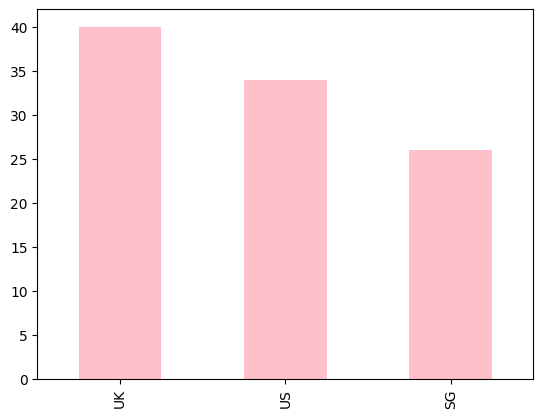

In [185]:
#plot customer country for the 100 customers (data_vis df)
data_cust.customer_country.value_counts().plot(kind='bar', color='pink')

In [186]:
## Counterparty Country

data.counterparty_country.value_counts().to_frame()

## We can see that United States, US and USA are included. 
## Hence, there is a need to change United States, US to USA

,counterparty_country
CN,619
UK,614
JP,537
US,494
DE,484
FR,455
HK,453
BR,392
SG,375
IN,340


In [187]:
data['counterparty_country'] = data['counterparty_country'].replace(['United States', 'US'], 'USA')

<AxesSubplot: title={'center': 'Total Number of Customers per Country'}>

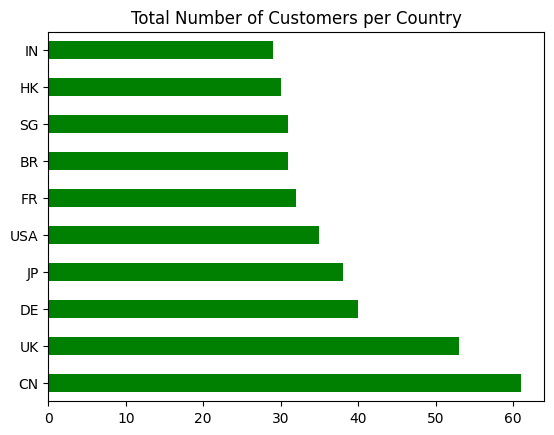

In [188]:
#plot counterparty country based on unique counterparties
data.drop_duplicates(subset=['counterparty','counterparty_country']).reset_index(drop=True).counterparty_country.value_counts().plot(kind='barh', color = 'green', title='Total Number of Customers per Country')

<AxesSubplot: >

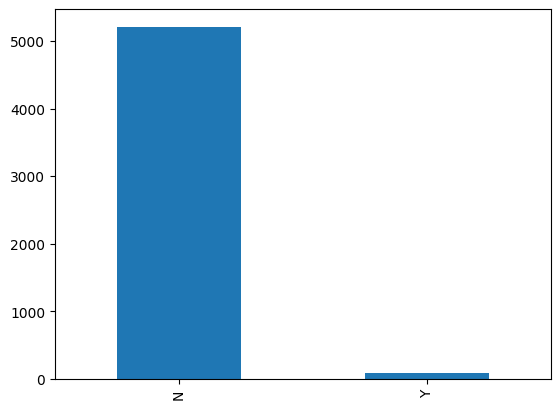

In [191]:
#plot value counts of y label
data.fraud_flag.value_counts().plot(kind='bar')

<AxesSubplot: >

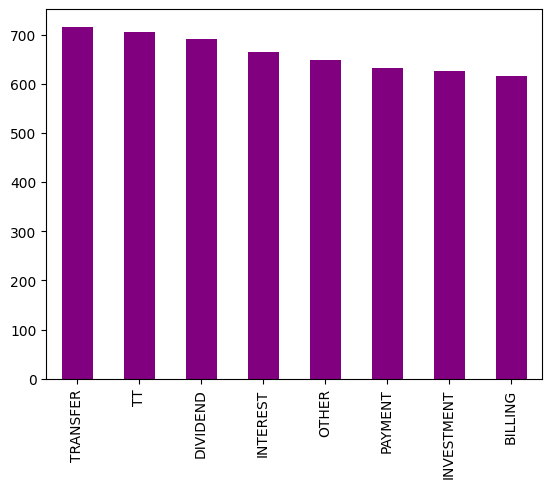

In [189]:
#plot count of different transaction types
data.type.value_counts().plot(kind='bar', color = 'purple')

<AxesSubplot: xlabel='type'>

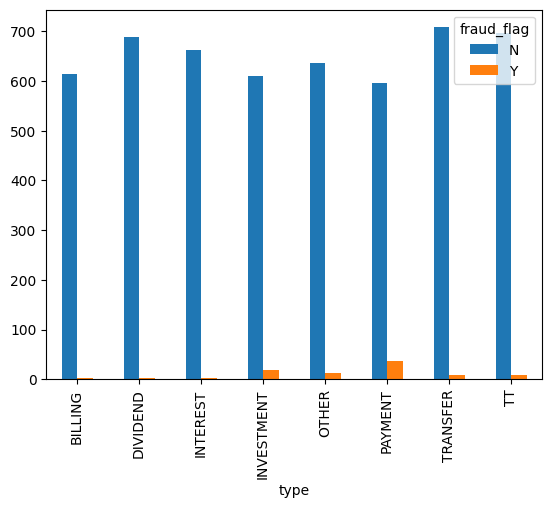

In [217]:
## Visualise distribution of y value for each transaction type
(data
 .groupby(['type', 'fraud_flag'])
 .size()
 .unstack()
 .plot.bar()
)

<AxesSubplot: xlabel='ccy'>

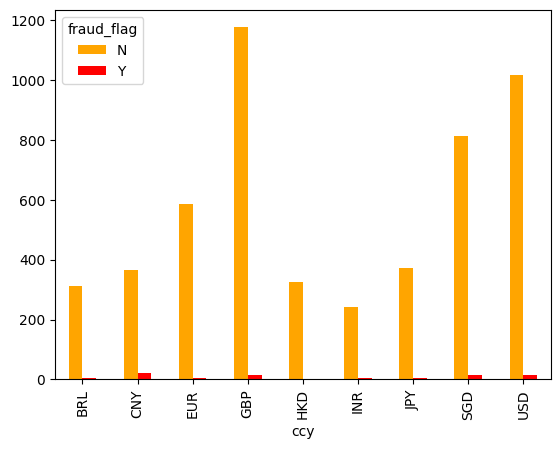

In [224]:
#plot count of types of currency
## Visualise distribution of y value for time of day
(data
 .groupby(['ccy', 'fraud_flag'])
 .size()
 .unstack()
 .plot.bar(color=['orange','red'])
)

In [192]:
## Since y value is low, we can do oversampling on minority class to increase model performance

<AxesSubplot: title={'center': 'amount'}, xlabel='fraud_flag'>

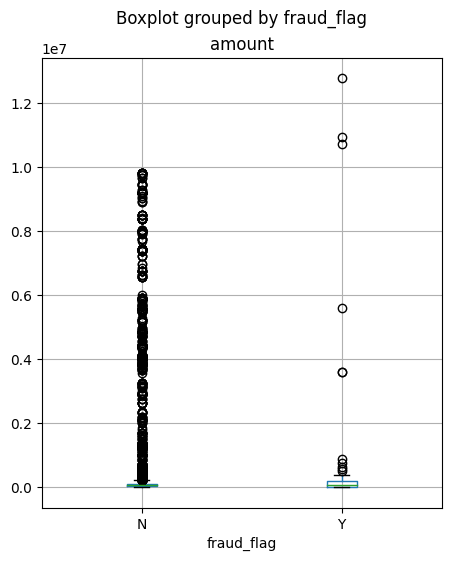

In [193]:
#box plot of relationship between fraud_flag and amount
data.boxplot(column='amount', by='fraud_flag', figsize=(5,6))

In [194]:
## create new column for month year
data['month_year'] = pd.to_datetime(data['timestamp']).dt.to_period('M')
data.head()

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount,month_year
0,C12976926337644,UK,N,2021-03-20 05:59:25,77697395249488,CN,OTHER,JPY,48625.25,2021-03
1,C12976926337644,UK,N,2021-05-02 03:00:38,77697395249488,CN,PAYMENT,GBP,20637.21,2021-05
2,C12976926337644,UK,N,2021-05-23 22:15:15,77697395249488,NaN,PAYMENT,USD,56691.27,2021-05
3,C12976926337644,UK,N,2021-07-07 21:36:50,77697395249488,NaN,PAYMENT,CNY,343864.71,2021-07
4,C12976926337644,UK,N,2021-09-02 00:14:03,77697395249488,NaN,PAYMENT,USD,57247.35,2021-09


In [201]:
## create new column for time of day
def timeofday(x):
    if (x>=0) & (x<6):
        tod = 'night'
    elif (x>=6) & (x<12):
        tod = 'morning'
    elif (x>=12) & (x<18):
        tod = 'afternoon'
    else:
        tod = 'evening'
    return tod

In [203]:
data['time'] = data.timestamp.dt.hour.map(timeofday) 

In [204]:
data

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount,month_year,time
0,C12976926337644,UK,N,2021-03-20 05:59:25,77697395249488,CN,OTHER,JPY,48625.25,2021-03,night
1,C12976926337644,UK,N,2021-05-02 03:00:38,77697395249488,CN,PAYMENT,GBP,20637.21,2021-05,night
2,C12976926337644,UK,N,2021-05-23 22:15:15,77697395249488,NaN,PAYMENT,USD,56691.27,2021-05,evening
3,C12976926337644,UK,N,2021-07-07 21:36:50,77697395249488,NaN,PAYMENT,CNY,343864.71,2021-07,evening
4,C12976926337644,UK,N,2021-09-02 00:14:03,77697395249488,NaN,PAYMENT,USD,57247.35,2021-09,night
...,...,...,...,...,...,...,...,...,...,...,...
5297,R85394663171656,UK,N,2021-12-20 00:34:56,88635938895767,UK,INTEREST,GBP,25774.25,2021-12,night
5298,R85394663171656,UK,N,2021-12-23 17:49:44,88635938895767,UK,INTEREST,GBP,25660.33,2021-12,afternoon
5299,R85394663171656,UK,N,2021-01-18 15:14:34,88635938895767,UK,OTHER,GBP,32242.92,2021-01,afternoon
5300,R85394663171656,UK,N,2021-04-03 00:13:03,88635938895767,UK,OTHER,GBP,32139.62,2021-04,night


<AxesSubplot: xlabel='month_year'>

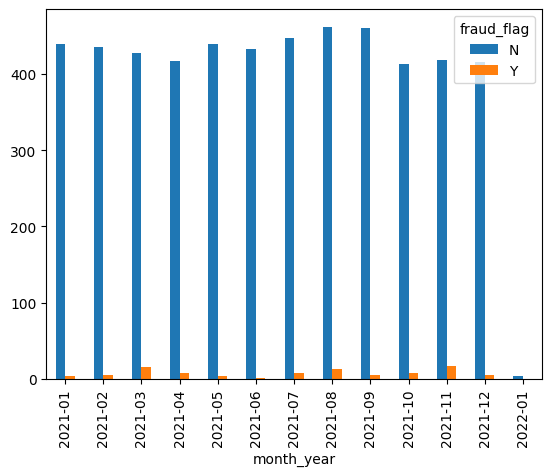

In [195]:
## Visualise distribution of y value for each month
(data
 .groupby(['month_year', 'fraud_flag'])
 .size()
 .unstack()
 .plot.bar()
)

<AxesSubplot: xlabel='time'>

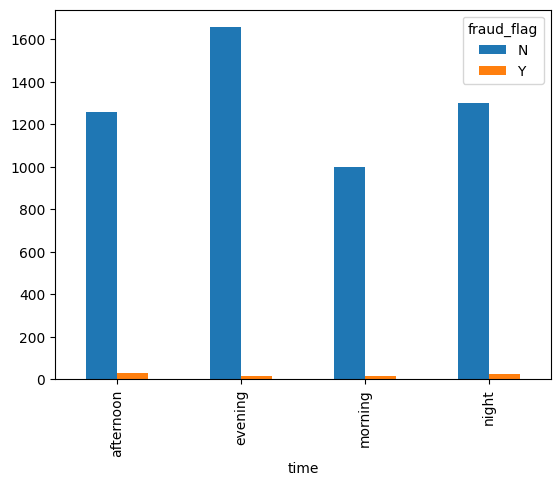

In [205]:
## Visualise distribution of y value for time of day
(data
 .groupby(['time', 'fraud_flag'])
 .size()
 .unstack()
 .plot.bar()
)

In [199]:
## focus on customers with high fraud_flag cases
data_fraud = data[data.fraud_flag=='Y'].reset_index(drop=True)

In [206]:
data_fraud.customer.value_counts()

P52769772532121    17
P45766486597685    13
P68755181269737    10
R35322123754253     6
K65138125882614     6
K33411671937212     4
P69485168569757     4
P42868171444816     3
P46374259491543     3
R22994327816589     2
P97111854441355     2
P76866373858451     2
C37595879336756     2
P21819235691331     2
K61564325711444     2
K32786635623393     2
K15538681292533     2
C82849917986274     2
C44573437474911     1
P79128454694118     1
R17354148795478     1
R18864868668596     1
R25394584372741     1
R45171421473354     1
R45832542755686     1
Name: customer, dtype: int64

### Modelling

In [143]:
## Model 1: use counterparty_country and drop NaN values
## Model 2: don't use counterparty_country (ignoring null values)

In [99]:
## Model 1

## We keep the counterparty_country as one of our features in the model. Hence we remove the NaN values
## and therefore remove the 499 missing values

In [147]:
data_model = data.dropna().reset_index(drop=True)

In [148]:
data_model.corr()

/var/folders/fp/chskv2v95k13ldv_jpwqql9c0000gn/T/ipykernel_52886/2127472397.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_model.corr()


,counterparty,amount
counterparty,1.000000,-0.035139
amount,-0.035139,1.000000


In [102]:
## For further data cleaning, we will do remapping of our binary features and creating dummy variables for our categorical features
## We will follow up with oversampling the minority class using SMOTE

In [149]:
## REMAP y value to integers (0,1)
data_model['fraud_flag'] = [0 if x == 'N' else 1 for x in data_model['fraud_flag']]

In [150]:
# Create dummy variables
dummy_customer_country = pd.get_dummies(data_model['customer_country'], prefix='cust_country', drop_first=True)
dummy_counterparty_country = pd.get_dummies(data_model['counterparty_country'], prefix='count_country', drop_first=True)
dummy_type = pd.get_dummies(data_model['type'], prefix='type', drop_first=True)
dummy_ccy = pd.get_dummies(data_model['ccy'], prefix='ccy', drop_first=True) 

In [151]:
# Drop unnecessary columns
to_drop = ['customer', 'customer_country', 'timestamp', 'counterparty',
           'counterparty_country', 'type', 'ccy','month_year']
data_model.drop(to_drop, axis=1, inplace=True)

In [152]:
data_model

,fraud_flag,amount
0,0,48625.25
1,0,20637.21
2,0,36944.25
3,0,48653.70
4,0,48765.81
...,...,...
4798,0,25451.05
4799,0,25774.25
4800,0,25660.33
4801,0,32242.92


In [153]:
# Merge dataframes into a single dataframe
merged_df = pd.concat([dummy_ccy,dummy_type,dummy_counterparty_country,dummy_customer_country,data_model], axis=1)
merged_df.head()

,ccy_CNY,ccy_EUR,ccy_GBP,ccy_HKD,ccy_INR,ccy_JPY,ccy_SGD,ccy_USD,type_DIVIDEND,type_INTEREST,...,count_country_HK,count_country_IN,count_country_JP,count_country_SG,count_country_UK,count_country_USA,cust_country_UK,cust_country_US,fraud_flag,amount
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,48625.25
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,20637.21
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,36944.25
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,48653.70
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,48765.81


In [154]:
## use MinMaxScaler to handle the large values of amount, 
## since machine learning algorithms will give more importance to variables on a larger scale

# Scale only columns that have values greater than 1
to_scale = [col for col in data_model.columns if data_model[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(merged_df[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Replace original columns with scaled ones
for col in scaled:
    merged_df[col] = scaled[col]
    
merged_df.head()

,ccy_CNY,ccy_EUR,ccy_GBP,ccy_HKD,ccy_INR,ccy_JPY,ccy_SGD,ccy_USD,type_DIVIDEND,type_INTEREST,...,count_country_HK,count_country_IN,count_country_JP,count_country_SG,count_country_UK,count_country_USA,cust_country_UK,cust_country_US,fraud_flag,amount
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.003799
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.001608
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.002885
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.003802
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.003810


In [155]:
## create model using SMOTE to oversample minority class

## Naive Approach

X = merged_df.drop('fraud_flag', axis=1)
y = merged_df['fraud_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print(f'''% Positive class in Train = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}
% Positive class in Test  = {np.round(y_test.value_counts(normalize=True)[1] * 100, 2)}''')

% Positive class in Train = 1.69
% Positive class in Test  = 1.67


##### We will start off with a simple Random Forest model, not accounting for class imbalance

##### Since we are focusing on fraudulent transactions, we want to ensure we identify all True positives accurately, hence we want to minimise our fall negative (FN) count

##### Main metric of evaluation should be Recall =  (TP/TP+FN)

Accuracy = 0.99
Recall = 0.40



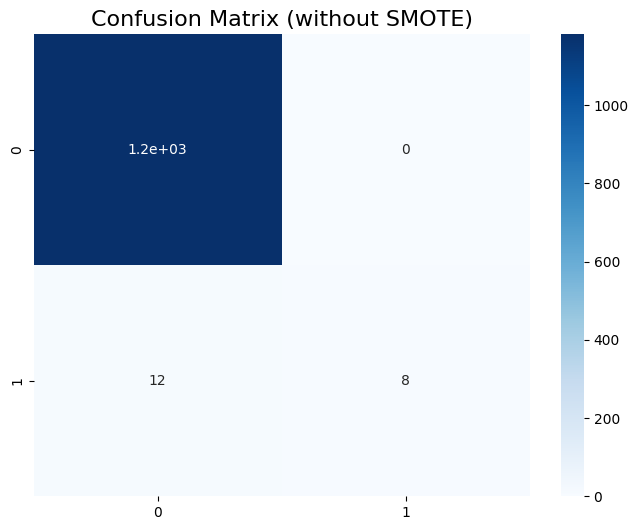

In [156]:
# Train
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluate
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (without SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

In [157]:
## as we can see for the simple random forest model, the model is being overfitted and is predicting the majority class, which is Y=0
## there is a need to handle class imbalance for our minority class

In [158]:
## handle class imbalance

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (4803, 27)
Shape of X after SMOTE: (9444, 27)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: fraud_flag, dtype: float64

Accuracy = 0.99
Recall = 0.99



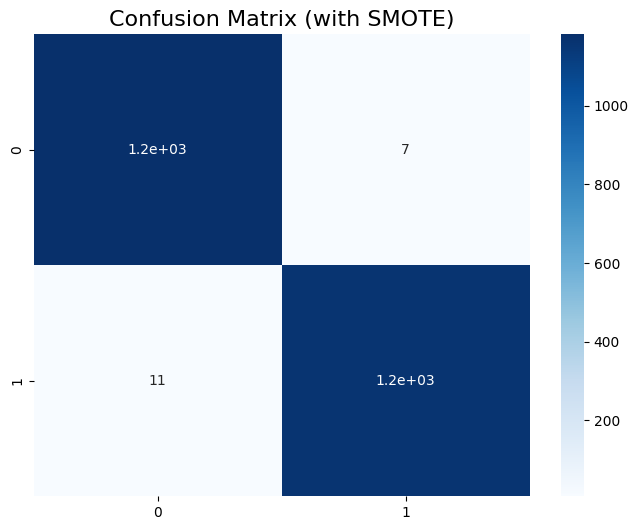

In [159]:
## random forest model with balanced dataset

X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.25, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (with SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

In [160]:
## feature importance scores

importances = model.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]
 
feat_labels = X.columns
 
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) amount                         0.259184
 2) type_PAYMENT                   0.065186
 3) cust_country_UK                0.054732
 4) count_country_JP               0.047096
 5) type_DIVIDEND                  0.047005
 6) type_INTEREST                  0.043502
 7) ccy_CNY                        0.038917
 8) ccy_USD                        0.037231
 9) cust_country_US                0.035012
10) type_INVESTMENT                0.027202
11) type_OTHER                     0.026739
12) ccy_GBP                        0.026045
13) count_country_CN               0.025877
14) ccy_HKD                        0.023911
15) type_TRANSFER                  0.023700
16) ccy_SGD                        0.022445
17) type_TT                        0.021074
18) count_country_IN               0.020616
19) ccy_JPY                        0.020093
20) count_country_DE               0.019620
21) count_country_SG               0.019530
22) count_country_UK               0.019375
23) count_country_HK            

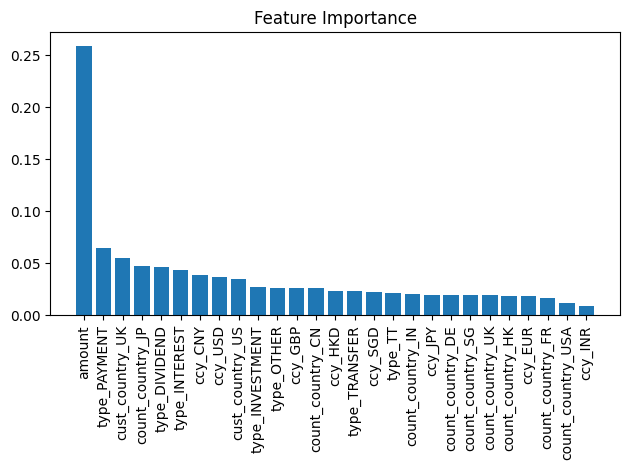

In [161]:
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

### Evaluation

In [208]:
## We notice that amount is a key feature with regards to predicting whether a transaction is fraudulent

In [218]:
## Our main metric of evaluation is recall

In [220]:
## Room for improvement
## Further look into timing interval between payments (ie two payments made within the same day)

In [221]:
data

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount,month_year,time
0,C12976926337644,UK,N,2021-03-20 05:59:25,77697395249488,CN,OTHER,JPY,48625.25,2021-03,night
1,C12976926337644,UK,N,2021-05-02 03:00:38,77697395249488,CN,PAYMENT,GBP,20637.21,2021-05,night
2,C12976926337644,UK,N,2021-05-23 22:15:15,77697395249488,NaN,PAYMENT,USD,56691.27,2021-05,evening
3,C12976926337644,UK,N,2021-07-07 21:36:50,77697395249488,NaN,PAYMENT,CNY,343864.71,2021-07,evening
4,C12976926337644,UK,N,2021-09-02 00:14:03,77697395249488,NaN,PAYMENT,USD,57247.35,2021-09,night
...,...,...,...,...,...,...,...,...,...,...,...
5297,R85394663171656,UK,N,2021-12-20 00:34:56,88635938895767,UK,INTEREST,GBP,25774.25,2021-12,night
5298,R85394663171656,UK,N,2021-12-23 17:49:44,88635938895767,UK,INTEREST,GBP,25660.33,2021-12,afternoon
5299,R85394663171656,UK,N,2021-01-18 15:14:34,88635938895767,UK,OTHER,GBP,32242.92,2021-01,afternoon
5300,R85394663171656,UK,N,2021-04-03 00:13:03,88635938895767,UK,OTHER,GBP,32139.62,2021-04,night
